# Analysis of toxic comments

The source file contains a dataset with markup on the toxicity of edits. The main task is to train the model to classify comments into positive and negative ones.

The online store is launching a new service where users can leave comments, it is necessary to make a model that will send negative comments for moderation.

**Основная цель**   
Define and build a model with a quality metric value *F1* of at least 0.75 for further use as a tool that will look for toxic comments and send them for moderation.

Описание данных:  

* Столбец *text* - содержит текст комментария
* Столбец *toxic* - целевой признак.

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook

In [2]:
df = pd.read_csv('/Users/andreyshagin/Downloads/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Checking for duplicates - none

In [4]:
df.duplicated().sum()

0

I check for gaps - none, preprocessing is not required

In [5]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

В столбце 'toxic' отмечен целевой признак, где 0 отмечены не токсичные комментарии, а 1 токсичные. Проверяю баланс в датафрейме токсичных и нет комментариев. Есть сильный дисбаланс: только 10% комментариев токсичные, остальные позитивные. При разделении выборок необходимо добавить параметр stratify.

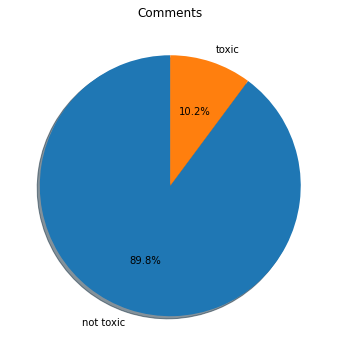

In [6]:
label = ['not toxic', 'toxic']
plt.figure(figsize=(6,6))
plt.pie(df['toxic'].value_counts(), labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Comments')
plt.show()

There are extra characters in the 'text' column, it is necessary to clear the text from them at the first stage.

In [7]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


I clean the text using regular expressions from unnecessary characters.

In [8]:
def clean_symbols(text):
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    return text.strip().lower()

In [9]:
df['text'] = df['text'].apply(clean_symbols)

Проверяю, что лишних символов больше нет.

In [10]:
df

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he matches this background colour i m s...,0
2,2,hey man i m really not trying to edit war it...,0
3,3,more i can t make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember...,0
...,...,...,...
159287,159446,and for the second time of asking when your v...,0
159288,159447,you should be ashamed of yourself that is a h...,0
159289,159448,spitzer umm theres no actual article for pro...,0
159290,159449,and it looks like it was actually you who put ...,0


I lemmatize using wordnetlemmatizer.
I also use the POS tag to determine the part of speech and assign a tag to it so that it can be correctly converted to the original form.
For example:  
Word      +    Type (POS tag)     —>     Lemmatized Word  
driving    +    verb      ‘v’            —>     drive  
dogs       +    noun      ‘n’           —>     dog  

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/andreyshagin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [14]:
def lemmatize (text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreyshagin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreyshagin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreyshagin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
df['text'] = df['text'].apply(lemmatize)

In [25]:
df['text']

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it look like it be actually you who put on...
159291    and i really don t think you understand i come...
Name: text, Length: 159292, dtype: object

In [19]:
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Analysis of the most popular words

Separate into separate words

In [22]:
def split(text):
    text_split = text.split()
    return text_split

In [23]:
df['text_split'] = df['text'].apply(split)

In [24]:
df

,Unnamed: 0,text,toxic,text_split
0,0,explanation edits make username hardcore metal...,0,"[explanation, edits, make, username, hardcore,..."
1,1,aww match background colour seemingly stick th...,0,"[aww, match, background, colour, seemingly, st..."
2,2,hey man really try edit war guy constantly rem...,0,"[hey, man, really, try, edit, war, guy, consta..."
3,3,make real suggestion improvement wonder sectio...,0,"[make, real, suggestion, improvement, wonder, ..."
4,4,sir hero chance remember page,0,"[sir, hero, chance, remember, page]"
...,...,...,...,...
159287,159446,second time ask view completely contradict cov...,0,"[second, time, ask, view, completely, contradi..."
159288,159447,ashamed horrible thing put talk page,0,"[ashamed, horrible, thing, put, talk, page]"
159289,159448,spitzer umm theres actual article prostitution...,0,"[spitzer, umm, theres, actual, article, prosti..."
159290,159449,look like actually put speedy first version de...,0,"[look, like, actually, put, speedy, first, ver..."


In [25]:
words = df['text_split']
allwords = []
for wordlist in words:
    allwords += wordlist

In [26]:
from nltk.probability import FreqDist

In [27]:
print(allwords[:20])

['explanation', 'edits', 'make', 'username', 'hardcore', 'metallica', 'fan', 'revert', 'vandalism', 'closure', 'gas', 'vote', 'new', 'york', 'doll', 'fac', 'please', 'remove', 'template', 'talk']


I make a graph for the 25 most popular words

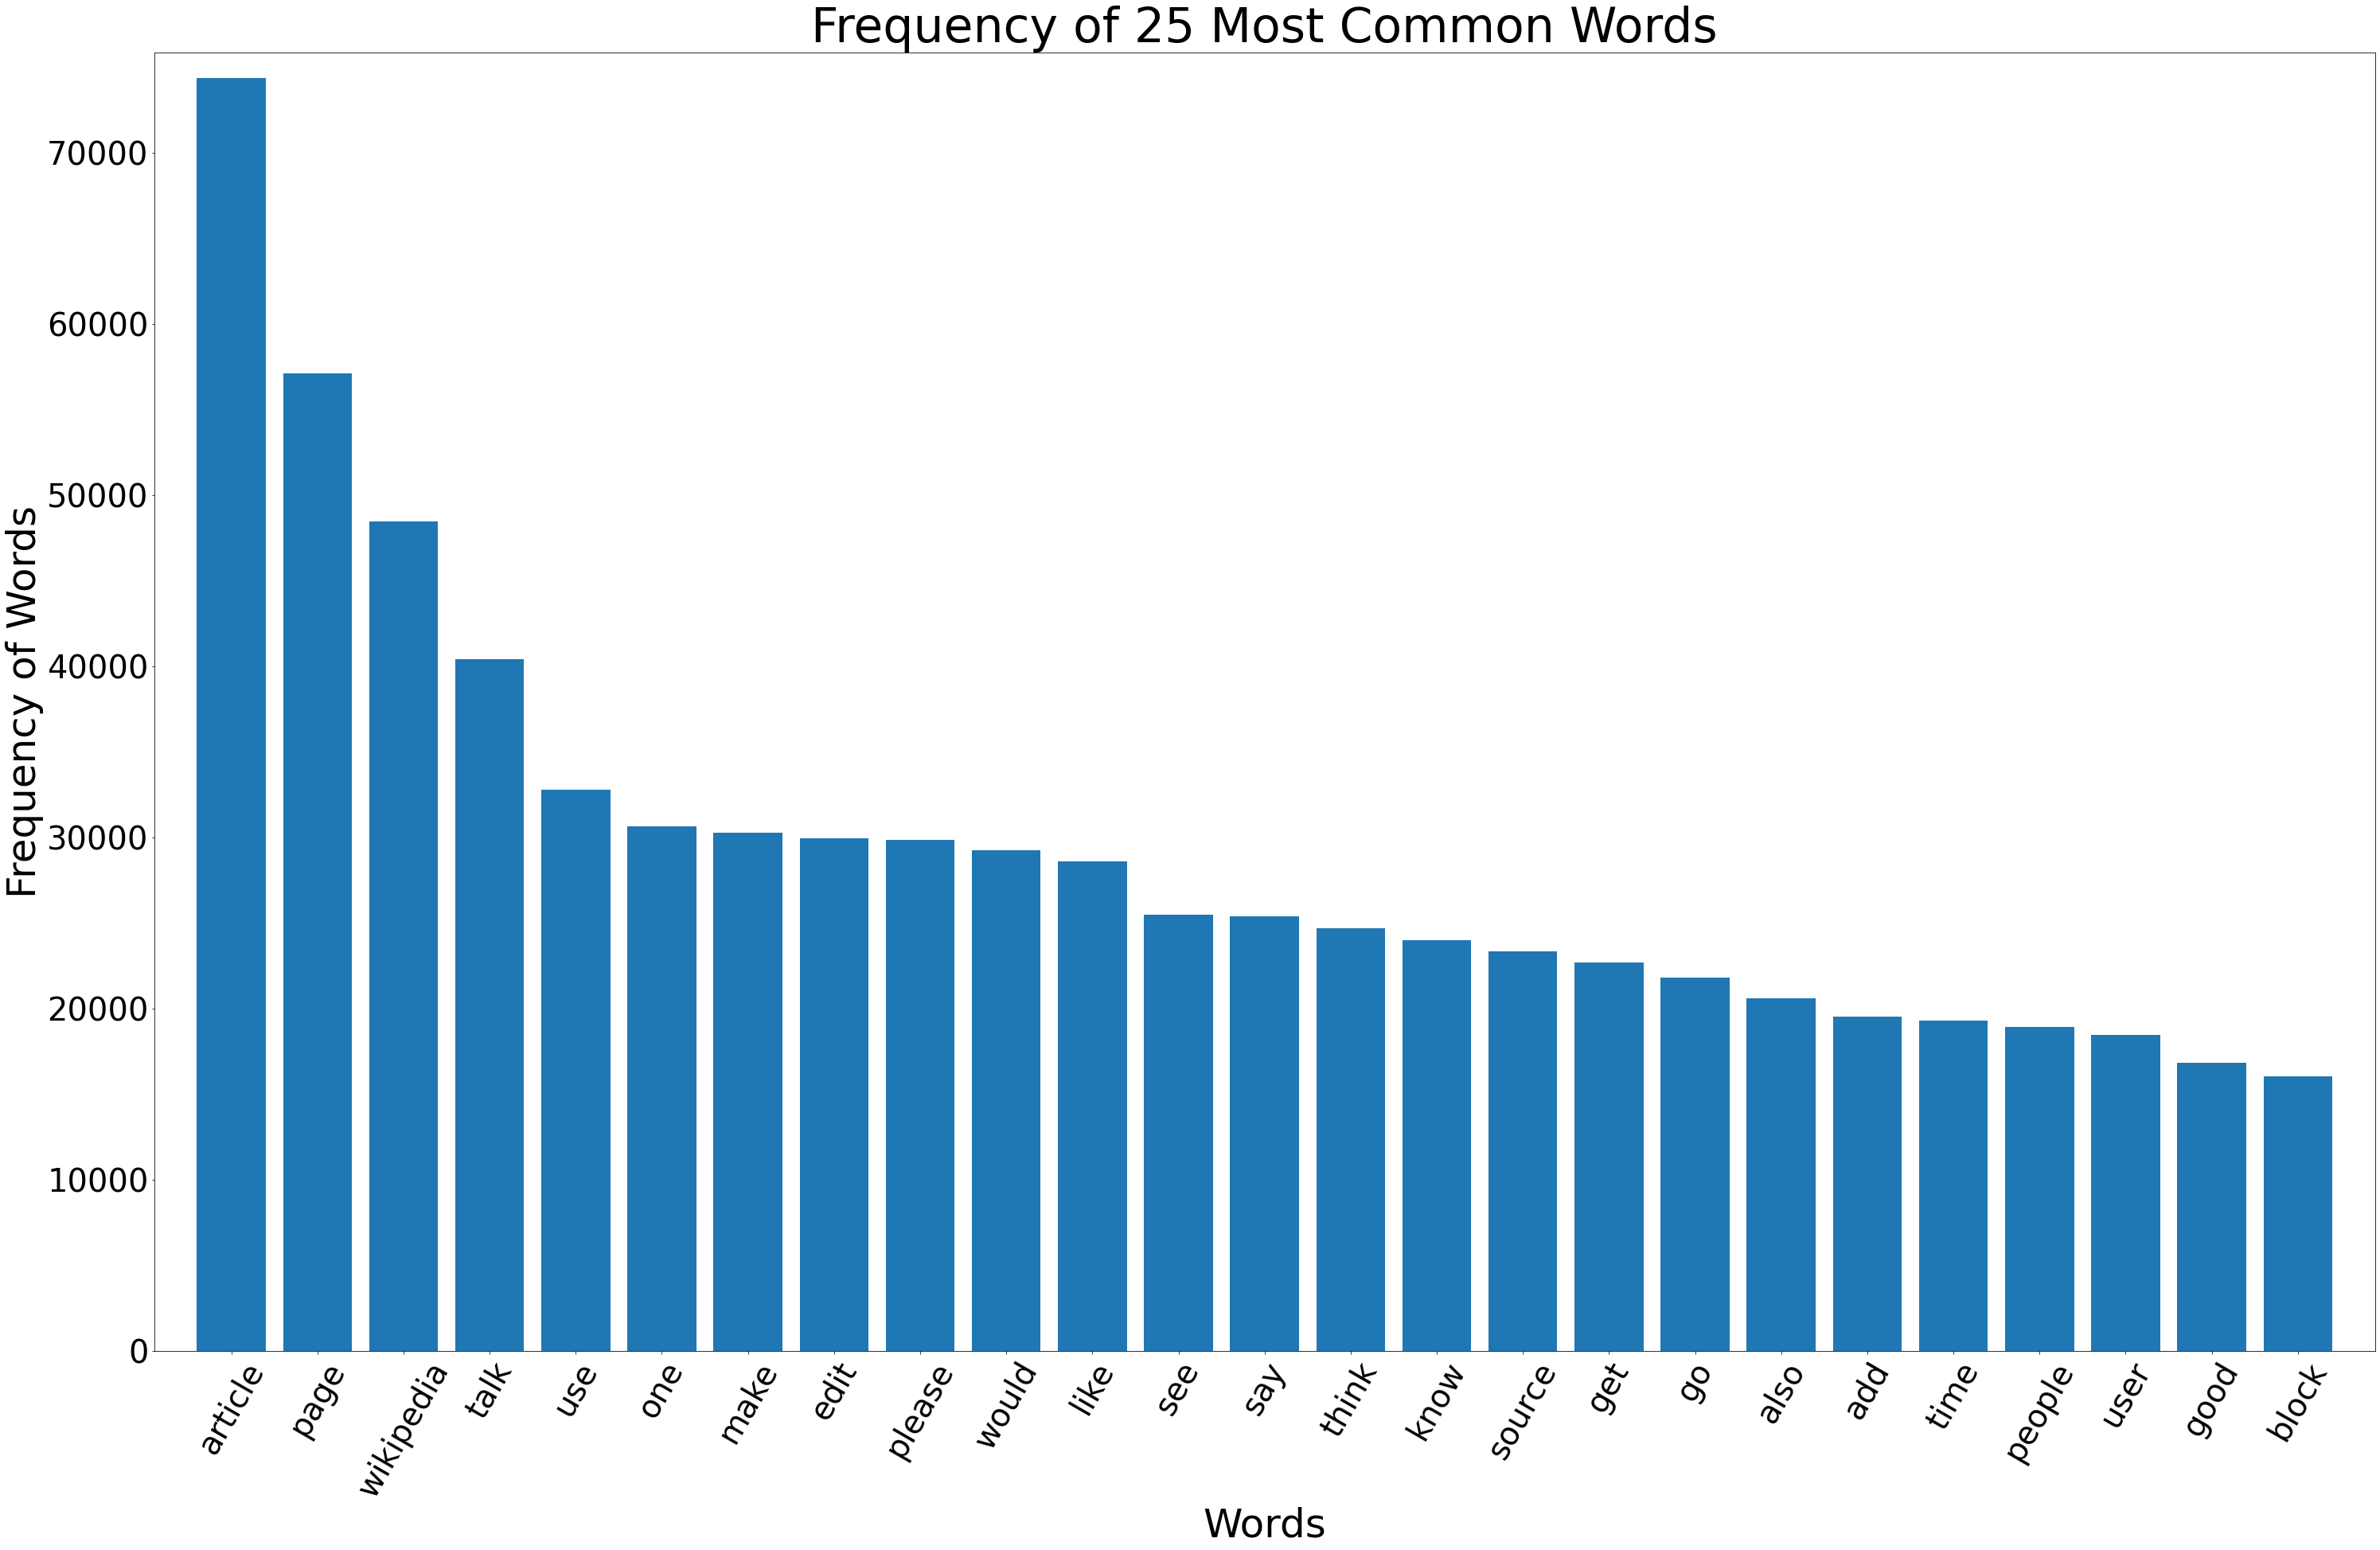

In [29]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

Также делаю визуализацию 100 самых популярных слов

In [30]:
!pip install wordcloud

In [31]:
from wordcloud import WordCloud

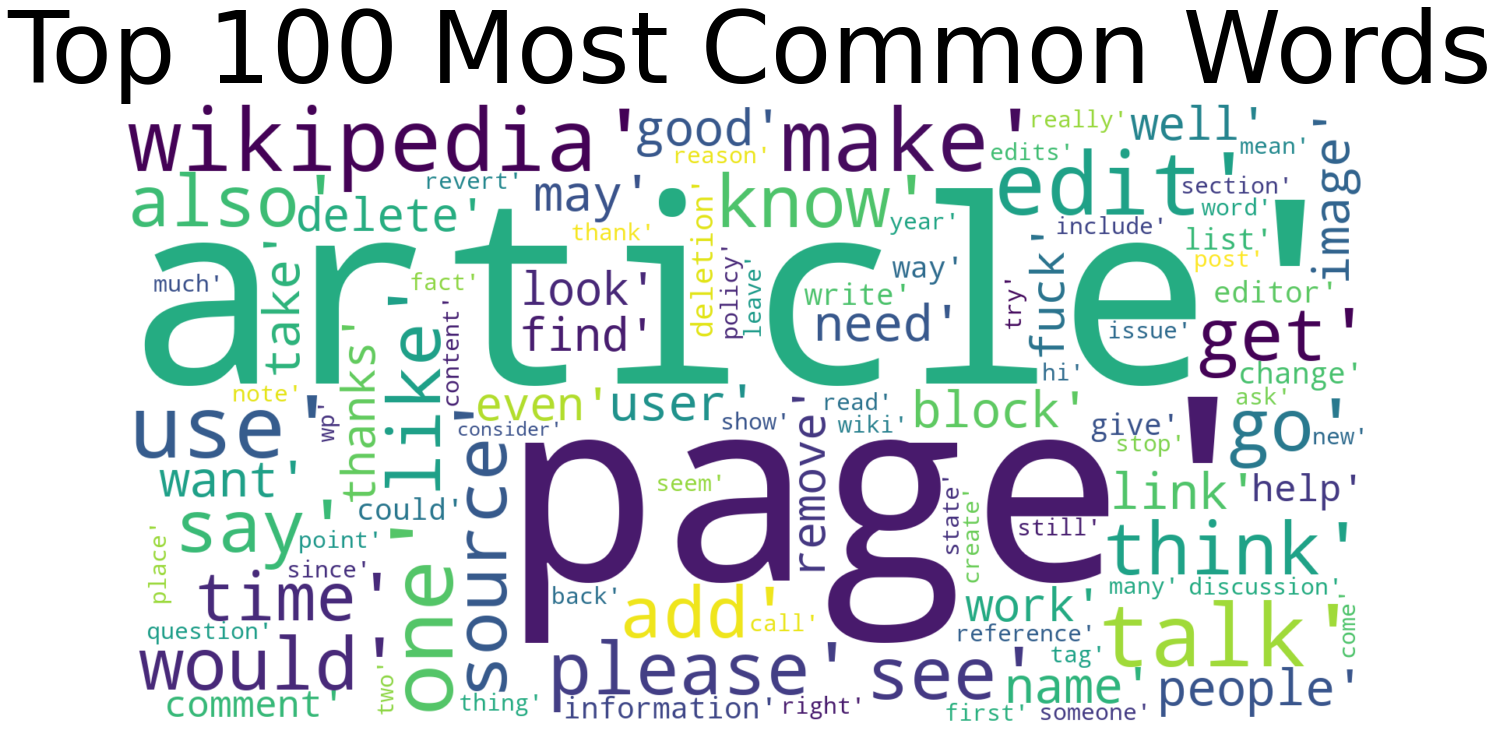

In [32]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

## Trainnig

Target variable 'toxic', attribute 'text'

In [33]:
features = df['text']
target = df['toxic']

I divide into samples in the ratio 60/20/20 training, validation, test sample. I add stratification to maintain balance.

In [34]:
features_train, features_valid_1, target_train, target_valid_1 = train_test_split(
    features, target, test_size=0.40, random_state=42, stratify = df['toxic'])

In [35]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_1, target_valid_1, test_size=0.50, random_state=42, stratify = target_valid_1)

Проверка размера выборок

In [36]:
def check_size (frames, start_frame):
    return display ("{0:.0%}".format(len(frames)/len(start_frame)))

In [37]:
check_size (features_valid, features)

'20%'

In [38]:
check_size (features_test, features)

'20%'

In [39]:
check_size (features_train, features)

'60%'

Checking the distribution of the target feature, in the original dataframe it was 90/10, the ratio is preserved

In [132]:
target_valid.value_counts(normalize=True)

0    0.898393
1    0.101607
Name: toxic, dtype: float64

In [133]:
target_test.value_counts(normalize=True)

0    0.898396
1    0.101604
Name: toxic, dtype: float64

I load stop words to account for words without semantic load

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreyshagin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [43]:
count_tf_idf

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

I calculate the importance score of TF IDF for a previously created corpus of texts for all samples

In [44]:
features_train_vector = count_tf_idf.fit_transform(features_train)
features_valid_vector = count_tf_idf.transform(features_valid)
features_test_vector = count_tf_idf.transform(features_test)

### Модель LogisticRegression

In [45]:
model_lr = LogisticRegression(random_state=42)

Train the model and make predictions with default parameters.

In [46]:
model_lr.fit (features_train_vector, target_train)

LogisticRegression(random_state=42)

The result turned out to be lower than the target, I select the parameters

In [47]:
model_lr_pred = model_lr.predict(features_valid_vector)
lr_f1 = f1_score(target_valid, model_lr_pred)
lr_f1

0.7327957997374837

For selection of parameters I use GridSearch

In [60]:
parameters_lr = {
    'class_weight':['balanced'],
    'C':[3],
    'max_iter':[300,400]}

In [61]:
grid_lr = GridSearchCV(model_lr, param_grid=parameters_lr, scoring='f1',verbose=3, cv=5, n_jobs=-1)

In [62]:
grid_lr.fit (features_train_vector, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3], 'class_weight': ['balanced'],
                         'max_iter': [300, 400]},
             scoring='f1', verbose=3)

In [63]:
lr_f1_grid = grid_lr.best_score_

The result corresponds to the target minimum of 0.75

In [64]:
lr_f1_grid

0.7551907404807491

In [65]:
grid_lr.best_params_

{'C': 3, 'class_weight': 'balanced', 'max_iter': 300}

###  DecisionTreeClassifier

Train the model and make predictions with default parameters.

In [66]:
model_tree = DecisionTreeClassifier(random_state = 42)

In [67]:
model_tree.fit (features_train_vector, target_train)

DecisionTreeClassifier(random_state=42)

The result turned out to be lower than the target, I also try to select hyperparameters to improve the indicator, also using GridSearch

In [68]:
model_tree_pred = model_tree.predict(features_valid_vector)
tree_f1 = f1_score(target_valid, model_lr_pred)
tree_f1

0.7327957997374837

In [81]:
parameters_tree = {'max_depth':[x for x in range(200,301,50)]}

In [82]:
grid_tree = GridSearchCV(model_tree, param_grid=parameters_tree,scoring='f1', verbose = 3)

In [83]:
grid_tree.fit (features_train_vector, target_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................max_depth=200;, score=0.712 total time=  54.3s
[CV 2/5] END .....................max_depth=200;, score=0.730 total time=  52.7s
[CV 3/5] END .....................max_depth=200;, score=0.725 total time=  53.9s
[CV 4/5] END .....................max_depth=200;, score=0.715 total time=  53.1s
[CV 5/5] END .....................max_depth=200;, score=0.725 total time=  55.4s
[CV 1/5] END .....................max_depth=250;, score=0.718 total time= 1.0min
[CV 2/5] END .....................max_depth=250;, score=0.722 total time= 1.0min
[CV 3/5] END .....................max_depth=250;, score=0.720 total time= 1.0min
[CV 4/5] END .....................max_depth=250;, score=0.710 total time= 1.0min
[CV 5/5] END .....................max_depth=250;, score=0.724 total time= 1.0min
[CV 1/5] END .....................max_depth=300;, score=0.720 total time= 1.1min
[CV 2/5] END .....................max_depth=300;,

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [200, 250, 300]}, scoring='f1',
             verbose=3)

In [84]:
tree_f1_grid = grid_tree.best_score_

In [85]:
tree_f1_grid

0.7213124226166673

The result is close to the model with default parameters, this model is not suitable for the current project.

In [86]:
model_tree_pred = grid_tree.predict(features_valid_vector)
tree_f1_tuned = f1_score(target_valid, model_tree_pred)
tree_f1_tuned

0.7191083831368115

In [87]:
grid_tree.best_params_

{'max_depth': 200}

###  CatBoost

In [88]:
pip install catboost

     |████████████████████████████████| 22.0 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 4.6 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [90]:
from catboost import CatBoostClassifier
from catboost.text_processing import Tokenizer

In [91]:
model_cat = CatBoostClassifier(learning_rate=0.5,
                          depth=3,
                         verbose = 100,
                              random_seed=42,
                              eval_metric = 'F1')

In [92]:
model_cat.fit (features_train_vector, target_train)

0:	learn: 0.3624319	total: 327ms	remaining: 5m 26s
100:	learn: 0.7414411	total: 16s	remaining: 2m 22s
200:	learn: 0.7772467	total: 32.1s	remaining: 2m 7s
300:	learn: 0.7947979	total: 49.3s	remaining: 1m 54s
400:	learn: 0.8143726	total: 1m 6s	remaining: 1m 38s
500:	learn: 0.8266115	total: 1m 23s	remaining: 1m 22s
600:	learn: 0.8316435	total: 1m 41s	remaining: 1m 7s
700:	learn: 0.8338389	total: 1m 57s	remaining: 50.2s
800:	learn: 0.8364719	total: 2m 13s	remaining: 33.3s
900:	learn: 0.8386137	total: 2m 30s	remaining: 16.5s
999:	learn: 0.8422373	total: 2m 46s	remaining: 0us


The model got the highest F1 score

In [93]:
model_cat_pred = model_cat.predict(features_valid_vector)
cat_f1 = f1_score(target_valid, model_cat_pred)
cat_f1

0.7617228204237584

Importing Pool and cv to cross validate with internal catboost tool

In [101]:
from catboost import Pool
from catboost import cv

In [102]:
train_data = Pool(data=train[X],
              label=train[y],
              cat_features = cat_features
              )

In [103]:
model_params = {'random_state': 42,
                'eval_metric': 'F1',
                'verbose': 100,
                'loss_function': 'Logloss',
                'learning_rate': 0.4}

In [104]:
cv_params = {'params': model_params,
             'pool': train_data,
             'fold_count': 3,
             'shuffle':True,
             'partition_random_seed':42,
             'stratified':True,
             'verbose': 100,
             'early_stopping_rounds':200}

In [105]:
cv_data = cv(**cv_params)

Training on fold [0/3]
0:	learn: 0.3476716	test: 0.3253785	best: 0.3253785 (0)	total: 1.02s	remaining: 16m 57s
100:	learn: 0.7776672	test: 0.7146530	best: 0.7146530 (100)	total: 43s	remaining: 6m 22s
200:	learn: 0.8209492	test: 0.7288197	best: 0.7295438 (198)	total: 1m 26s	remaining: 5m 45s
300:	learn: 0.8336377	test: 0.7339087	best: 0.7339087 (300)	total: 2m 7s	remaining: 4m 56s
400:	learn: 0.8432339	test: 0.7360515	best: 0.7360515 (397)	total: 2m 45s	remaining: 4m 7s
500:	learn: 0.8533402	test: 0.7369546	best: 0.7374043 (489)	total: 3m 23s	remaining: 3m 22s
600:	learn: 0.8676871	test: 0.7384124	best: 0.7403335 (567)	total: 4m 7s	remaining: 2m 44s
700:	learn: 0.8820556	test: 0.7405836	best: 0.7405836 (697)	total: 4m 51s	remaining: 2m 4s
800:	learn: 0.9127749	test: 0.7424135	best: 0.7437434 (795)	total: 5m 28s	remaining: 1m 21s
900:	learn: 0.9479008	test: 0.7422246	best: 0.7444230 (875)	total: 6m 6s	remaining: 40.3s
999:	learn: 0.9750118	test: 0.7433690	best: 0.7444230 (875)	total: 6m 

In [106]:
model3 = CatBoostClassifier(**model_params)

In [107]:
model3.fit(train_data)

0:	learn: 0.3624319	total: 1.27s	remaining: 21m 13s
100:	learn: 0.7689801	total: 56.8s	remaining: 8m 25s
200:	learn: 0.8057150	total: 1m 48s	remaining: 7m 10s
300:	learn: 0.8293921	total: 2m 36s	remaining: 6m 3s
400:	learn: 0.8352495	total: 3m 26s	remaining: 5m 7s
500:	learn: 0.8420029	total: 4m 13s	remaining: 4m 12s
600:	learn: 0.8497976	total: 5m 1s	remaining: 3m 20s
700:	learn: 0.8560722	total: 5m 52s	remaining: 2m 30s
800:	learn: 0.8637904	total: 6m 38s	remaining: 1m 38s
900:	learn: 0.8714398	total: 7m 24s	remaining: 48.8s
999:	learn: 0.8823826	total: 8m 10s	remaining: 0us


The result is insignificant, but increased from 0.761 to 0.764, then I check it on test samples

In [110]:
model_cat_pred3 = model3.predict(features_valid_vector)
cat_f13 = f1_score(target_valid, model_cat_pred3)
cat_f13

0.7640138408304499

### Checking on the test set

The best logistic regression model on the test sample also has a score above the target of 0.75

In [111]:
pred_test_lr = grid_lr.predict(features_test_vector)
f1_test_lr = f1_score(target_test, pred_test_lr)
f1_test_lr

0.7518351214003388

The CatBoost model with cv hits the target of 0.75. The result is better than the logistic regression of 0.756 vs. 0.751.

In [113]:
pred_test1 = model_cat.predict(features_test_vector)
f1_test_cat = f1_score(target_test, pred_test1)
f1_test_cat

0.7467659046606415

In [114]:
pred_test3 = model3.predict(features_test_vector)
f1_test_cat3 = f1_score(target_test, pred_test3)
f1_test_cat3

0.7567853366231935

I make a pivot table with the results of all models and the results on the test sample.

In [117]:
LogisticRegression = {'F1': lr_f1}
LogisticRegression_tuned = {'F1': lr_f1_grid}
DecisionTreeClassifier = {'F1': tree_f1}
DecisionTreeClassifier_tuned = {'F1': tree_f1_tuned}
CatBoostRegressor = {'F1': cat_f1}
CatBoostRegressor_cv = {'F1': cat_f13}
LogisticRegression_test = {'F1': f1_test_lr}
CatBoostRegressor_cv_test = {'F1': f1_test_cat3}

In [118]:
Summary_table = pd.DataFrame([LogisticRegression, LogisticRegression_tuned, DecisionTreeClassifier, DecisionTreeClassifier_tuned, CatBoostRegressor, CatBoostRegressor_cv, LogisticRegression_test,CatBoostRegressor_cv_test],
                     index=['LogisticRegression', 'LogisticRegression_tuned', 'DecisionTreeClassifier', 'DecisionTreeClassifier_tuned', 'CatBoostRegressor', 'CatBoostRegressor_cv', 'LogisticRegression_test', 'CatBoostRegressor_cv_test'])
Summary_table


,F1
LogisticRegression,0.732796
LogisticRegression_tuned,0.755191
DecisionTreeClassifier,0.732796
DecisionTreeClassifier_tuned,0.719108
CatBoostRegressor,0.761723
CatBoostRegressor_cv,0.764014
LogisticRegression_test,0.751835
CatBoostRegressor_cv_test,0.756785


## Выводы

It is recommended to use the CatBoost model as a tool that will look for toxic comments and send them for moderation.
On the validation set, the CatBoost model showed an F1 result of 0.764, on the test set 0.756.